In [1]:
import sklearn as sk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
#for each row, gneerate data which has a gaussian dist with mean of city center
#np.random.rand
#city 
num_cities = 4
dim = 2
cities_locations = np.random.rand(num_cities, dim)
probs = [0.3,0.3,0.2,0.2]
pop = 1000
X = np.zeros([pop,dim])
for i in range(pop):
  city = np.random.choice(np.arange(0,4),p=probs)
  center = cities_locations[city,:]
  X[i] = np.random.normal(loc = center,scale = 0.1,size = (1,dim))

In [2]:
#create a weights, means, and covariance matrix
def prepareGMM(k,X):
  dim = 2 
  #fill the weights with random numbres between 0,1
  weights = np.random.rand(k)
  weights = weights/np.sum(weights)
  means = np.random.rand(k,dim)
  cov = []
  for i in range(k):
    cov.append(make_spd_matrix(X.shape[1]))
  cov = np.array(cov)
  return means, cov, weights



#Need to break the algorithm into the E and M steps
def estimate_gmm(X, k, eps=1e-8, max_iter=100):
  # 0. Initialize theta = (mu, sigma, pi) and dimension of data
  means, cov, weights = prepareGMM(k,X)
  dim =2 

  #DP parameters
  epsilon = 1.
  delta = .0001
  c2 = 2*np.log(1.25/delta)

  for step in range(max_iter):
    
    score = []
    responsibility = []
    # Expectation step, use the built sklearn multivariate normal -> credit to some Towards Data Science article for pointing out a way to do this
    #Essentially, we want to predict the likelihood that each point belongs to one of the means  
    
    # Responsibilities calculation, this is equation 10 in the paper
    for j in range(k):
      score.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]) *weights[j])

    for j in range(k):
      responsibility.append(score[j] / np.sum(score,axis=0))

    #add privacy to the weights
    weights_sens = 2./X.shape[0]
    nsv = c2*(weights_sens**2)/(epsilon**2)
    nse_mat = np.random.normal(0,scale=np.sqrt(nsv),size = weights.shape)
    w = weights+nse_mat   
    
    #weights fixing:
    #here, we sum the weights and check if they are equal to one.
    #if they are not, we add the difference to the first element
    #this will be fine tuned later.
    if np.sum(np.array(weights)) != 1:
      diff = 1.-np.sum(np.array(weights))
      weights[0] = weights[0]-diff
    
    if np.any(weights) < 1:
      weights = np.clip(weights, 0.1, 1000)
      weights = weights/np.mean(weights)

    #add privacy to the means
    #Note, we have an error where is the mean is outside of the unit square
    #it will throw off the probabilities, need to correct this somehow
    #Currently, it is corrected for by regenerating the noise until the mean in question
    # is within the unit square, seems to trigger an infinite while loop
    for i in range(k):
      means_sens = 2./np.sum(weights[i])
      nsv = c2*(means_sens**2)/(epsilon**2)

      temp = means[i] + np.random.normal(0,np.sqrt(nsv),size = (1,dim))
      if np.all(temp <0):
        temp = np.array([.00001,.00001])
      elif np.all(temp >1):
        temp = np.array([.999999,.99999])
      elif np.any(temp > 1) or np.any(temp<0):
        ones = np.ones((2,2))
        zeroes = np.zeros((2,2))
        dist1 = np.linalg.norm(temp - ones)
        dist2 = np.linalg.norm(temp - zeroes)
        if dist1 < dist2:
          temp = np.array([.999999,.99999])
        else:
          temp = np.array([.00001,.00001])
      else:
        means[i] = temp




    #covariances,currently broken
    for i in range(k):
      cov_i = cov[i]
      cov_sens = 2./np.sum(weights[i])
      nsv = np.sqrt((c2*(cov_sens**2)/(epsilon**2))*np.identity(2))
      nse_mat = np.random.normal(0,nsv,[dim,dim])
      upper_nse_mat = np.triu(nse_mat, 0)
      for i in range(dim):
        for j in range(i, dim):
          upper_nse_mat[j][i] = upper_nse_mat[i][j]
      
      cov_i = cov_i + upper_nse_mat
      w, v = np.linalg.eig(cov_i)
      neg_idx = np.nonzero(w<0)
      w[neg_idx] = 0.0001
      cov_i = np.dot(v, np.dot(np.diag(w), v.transpose()))

      cov[i] = cov_i

    # Maximization step 
    for j in range(k):
      # update mean and variance based on the observation
      means[j] = np.sum(responsibility[j].reshape(len(X),1) * X, axis=0) / (np.sum(responsibility[j]))
      cov[j] = np.dot((responsibility[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(responsibility[j]))
      weights[j] = np.mean(responsibility[j])

    #add privacy to the weights, see comment above
    weights_sens = 2/X.shape[0]
    nsv = c2*(weights_sens**2)/(epsilon**2)
    nse_mat = np.random.normal(0,np.sqrt(nsv),size = weights.shape)
    w = weights+nse_mat  

    if np.any(weights) < 1:
      weights = np.clip(weights, 0.1, 1000)
      weights = weights/np.mean(weights)

    #weights fixing, see comment above
    if np.sum(np.array(weights)) != 1:
      diff = 1.-np.sum(np.array(weights))
      weights[0] = weights[0]-diff

    #add privacy to the means, see comment above
    for i in range(k):
      means_sens = 2./np.sum(weights[i])
      nsv = c2*(means_sens**2)/(epsilon**2)
      temp = means[i] + np.random.normal(0,np.sqrt(nsv),size = (1,dim))

      if np.all(temp <0):
        temp = np.array([.00001,.00001])
      elif np.all(temp >1):
        temp = np.array([.999999,.99999])
      elif np.any(temp > 1) or np.any(temp<0):
        ones = np.ones((2,2))
        zeroes = np.zeros((2,2))
        dist1 = np.linalg.norm(temp - ones)
        dist2 = np.linalg.norm(temp - zeroes)
        if dist1 < dist2:
          temp = np.array([.999999,.99999])
        else:
          temp = np.array([.00001,.00001])
      else:
        means[i] = temp

    #covariances,currently broken
    for i in range(k):
      cov_i = cov[i]
      cov_sens = 2./np.sum(weights[i])
      nsv = np.sqrt((c2*(cov_sens**2)/(epsilon**2))*np.identity(2))
      nse_mat = np.random.normal(0,nsv,[dim,dim])
      upper_nse_mat = np.triu(nse_mat, 0)
      for i in range(dim):
        for j in range(i, dim):
          upper_nse_mat[j][i] = upper_nse_mat[i][j]
      
      cov_i = cov_i + upper_nse_mat
      w, v = np.linalg.eig(cov_i)
      neg_idx = np.nonzero(w<0)
      w[neg_idx] = 0.0001
      cov_i = np.dot(v, np.dot(np.diag(w), v.transpose()))

      cov[i] = cov_i

    print("new means")
    print(means)
  return weights,means,cov

[[0.79214032 0.18334995]
 [0.97223497 0.71545964]
 [0.25630182 0.06378273]
 [0.02578314 0.24108176]]

 Entering GMM
new means
[[0.66052083 0.38556182]
 [0.57478982 0.35705003]
 [0.54338685 0.31944555]
 [0.58351474 0.29920178]]
new means
[[0.69337673 0.42622897]
 [0.27282655 0.35533564]
 [0.538531   0.33354966]
 [0.58578509 0.31444409]]
new means
[[0.72775522 0.45511942]
 [0.21309534 0.38681473]
 [0.51640329 0.33178051]
 [0.57796945 0.31307755]]
new means
[[0.78461856 0.50062162]
 [0.21309532 0.38681473]
 [0.50086567 0.32858531]
 [0.57457773 0.30902098]]
new means
[[0.85408653 0.56180019]
 [0.55919183 0.35503813]
 [0.48058569 0.32249493]
 [0.56780853 0.30146958]]
new means
[[0.91404732 0.6259758 ]
 [0.56817035 0.16241104]
 [0.4508895  0.30872599]
 [0.55317987 0.28544401]]
new means
[[0.93729413 0.65996839]
 [0.57556617 0.13484704]
 [0.40068669 0.27802886]
 [0.52168916 0.25190261]]
new means
[[0.94621584 0.67747017]
 [0.58620024 0.14196362]
 [0.34106524 0.2368998 ]
 [0.48082524 0.2083334

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


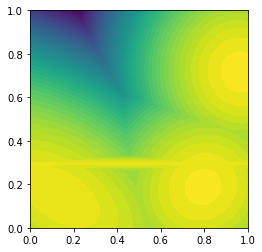

In [3]:
print(cities_locations)
print("\n Entering GMM")
w,m,c = estimate_gmm(X,num_cities)

print(m)

 #make grid resolution on the unit square
lin_param = (0., 1., 100)
x = np.linspace(*lin_param)
y = np.linspace(*lin_param)

xx, yy = np.meshgrid(x, y)
pos = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis = 1)

k=num_cities
#evaluate v on a grid by finding the likelhood one point on the grid belongs to the 
likelihood = []
print("you are here")



for j in range(len(pos)):
  likelihood.append( [np.log(multivariate_normal.pdf(x=pos[j], mean=m[t], cov=c[t])) for t in range(k)] )


#get the probability 
likelihood = np.asarray(likelihood)
np.nan_to_num(likelihood)

probs = []
for l in range(len(likelihood)):
  probs.append(max(likelihood[l]))

textfile = open("a_file.txt", "w")

textfile.write(str(probs))

textfile.close()

probs = np.asarray(probs)
probs = probs.reshape(xx.shape)

plt.contourf(x, y, probs, 50, cmap="viridis")
plt.axis('square')
plt.show()

Scikit Learn GMM (Quality Control)

(10000,)


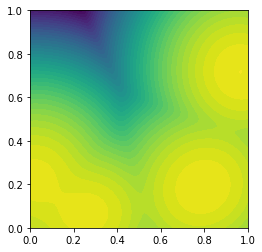

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
gm = GaussianMixture(n_components=num_cities, random_state=0).fit(X)
#create a grid with some points on it
lin_param = (0., 1., 100)
x = np.linspace(*lin_param)
y = np.linspace(*lin_param)

xx, yy = np.meshgrid(x, y)
pos = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis = 1)



z = gm.score_samples(pos) 
print(z.shape)
z = z.reshape(xx.shape)

plt.contourf(x, y, z, 50, cmap="viridis")
plt.axis('square')
plt.show()

EM from scratch (Quality Control)

In [5]:
#Need to break the algorithm into the E and M steps
def estimate_gmm_2(X, k, eps=1e-8, max_iter=100):
  # 0. Initialize theta = (mu, sigma, pi) and dimension of data
  means, cov, weights = prepareGMM(k,X)
  dim =2 

  for step in range(max_iter):
    
    score = []
    responsibility = []
    # Expectation step, use the built sklearn multivariate normal -> credit to some Towards Data Science article for pointing out a way to do this
    #Essentially, we want to predict the likelihood that each point belongs to one of the means

    # Responsibilities calculation, this is equation 10 in the paper
      #calculate scores first, then normalize
    for j in range(k):
      score.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]) *weights[j])

    for j in range(k):
      #x = multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j])
      responsibility.append(score[j] / np.sum(score,axis=0))

    #for j in range(k):
      #responsibility.append((multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]) * weights[j]) / (np.sum([multivariate_normal.pdf(x=X, mean=means[i], cov=cov[i]) * weights[i] for i in range(k)], axis=0)))
    # Maximization step 
    for j in range(k):
      # update mean and variance based on the observation
      means[j] = np.sum(responsibility[j].reshape(len(X),1) * X, axis=0) / (np.sum(responsibility[j]))
      cov[j] = np.dot((responsibility[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(responsibility[j]))
      weights[j] = np.mean(responsibility[j])
  return weights,means,cov

[[0.79214032 0.18334995]
 [0.97223497 0.71545964]
 [0.25630182 0.06378273]
 [0.02578314 0.24108176]]

 Entering GMM


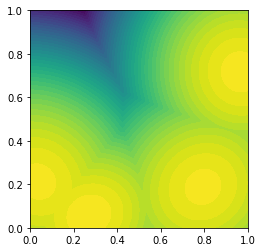

In [6]:
print(cities_locations)
print("\n Entering GMM")
w,m2,c = estimate_gmm_2(X,num_cities)


 #make grid resolution on the unit square
lin_param = (0., 1., 100)
x = np.linspace(*lin_param)
y = np.linspace(*lin_param)

xx, yy = np.meshgrid(x, y)
pos = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis = 1)

k=num_cities
#evaluate v on a grid by finding the likelhood one point on the grid belongs to the 
likelihood = []
for j in range(len(pos)):
  likelihood.append( [np.log(multivariate_normal.pdf(x=pos[j], mean=m2[t], cov=c[t])) for t in range(k)] )

#get the probability 
likelihood = np.asarray(likelihood)


probs = []
for l in range(len(likelihood)):
  probs.append(max(likelihood[l]))

probs2 = np.asarray(likelihood)
probs = np.asarray(probs)
probs = probs.reshape(xx.shape)

plt.contourf(x, y, probs, 50, cmap="viridis")
plt.axis('square')
plt.show()

Print Statements for Debugging

In [7]:
#print(m)
#print(gm.means_)
print(gm.covariances_)
print(c)
#print(cities_locations)

[[[ 9.90536997e-03  3.15625634e-04]
  [ 3.15625634e-04  7.89447350e-03]]

 [[ 8.91979174e-03 -2.38068228e-04]
  [-2.38068228e-04  9.75144395e-03]]

 [[ 1.07590529e-02  9.74652865e-04]
  [ 9.74652865e-04  1.03965630e-02]]

 [[ 9.18019012e-03  2.80700210e-05]
  [ 2.80700210e-05  1.00292837e-02]]]
[[[ 0.00891875 -0.00023847]
  [-0.00023847  0.0097474 ]]

 [[ 0.00895873  0.00088057]
  [ 0.00088057  0.00751211]]

 [[ 0.01053467 -0.00100793]
  [-0.00100793  0.01070709]]

 [[ 0.01075846  0.0009818 ]
  [ 0.0009818   0.01040153]]]
